In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_HIGHTOL.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv_HIGHTOL.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

In [2]:
# Full 6D r,v elements

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545489,15563.916192,266.913396,-1.142984,2.852848,0.048528
2,30572.240101,28909.065576,496.928457,-2.127756,2.228986,0.039518
3,17596.058985,38144.724801,671.355898,-2.813645,1.287414,0.027234
4,2068.443209,41949.722913,775.646911,-3.098444,0.161674,0.012698
...,...,...,...,...,...,...
995,38234.560983,21122.626943,-7729.980003,-0.857195,2.210305,1.746021
996,31594.564686,31056.038869,1622.694286,-1.676526,1.578339,1.821188
997,21172.777063,37155.711937,10779.298456,-2.301089,0.745975,1.670545
998,8179.033302,38600.411058,18585.398385,-2.656710,-0.200198,1.303776


Function to train model on ONE column:

In [3]:
#Function

def train_vector(df, str):
    
    #Create a new dataframe with only the column
    data = df.filter([str]) # CHANGE FOR Y,Z
    #Convert the dataframe to a numpy array
    dataset = data.values
    #Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * 0.8 ))
    train=dataset[0 : training_data_len]
    test=dataset[training_data_len - 60 : ]

    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train)
    test_data=scaler.transform(test)
    
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            pass
            #print(x_train)
            #print(y_train)
            #print()      
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)
    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    #Create the testing data set
    #Create a new array containing scaled values
    #Create the data sets x_test and y_test
    x_test = []
    #y_test = dataset[training_data_len:, :]
    y_test = dataset[training_data_len : ]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    
    #Build the LSTM model
    # Note: replace LSTM with GRU or RNN if you want to try those
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    #Train the model
    history = model.fit(x_train, y_train, batch_size=256, epochs=100) # 100 epochs
    
    # Plot Training Loss
    plt.figure(figsize=(16,8))
    plt.plot(history.history['loss']) # add validation loss
    #plt.plot(history.history['val_loss']) # add validation loss
    #plt.title('Autoencoder model training losses', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    plt.legend(['Loss (Mean Squared Error)'], loc='upper right', fontsize=18)
    plt.show()
    
    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    #print(predictions)
    pred=np.reshape(predictions, (predictions.shape[0]))
    pred_s=pd.Series(pred)
    # Init empty predictions DF
    #df_pred= pd.DataFrame(columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv'])
    df_pred[str]=pred_s
    
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print('\n RMSE:')
    print(rmse)
    
    # Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Visualization of vector '+str)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel(str+'-Coord', fontsize=18)
    plt.plot(train[str])
    plt.plot(valid[[str, 'Predictions']])
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    plt.show()

    # Error plot
    valid['Error']=abs(valid.Predictions-valid[str])/6738 # the normalization ct is taken as ISS semi-major axis
    valid.Error.plot()
    
    #Output dataframe of predictions in 6 dimensions r,v
    return df_pred

We want to train all the 6 separate state space elements:

Epoch 1/100
3/3 [==============================] - 0s 123ms/step - loss: 0.3200
Epoch 2/100
3/3 [==============================] - 0s 109ms/step - loss: 0.1538
Epoch 3/100
3/3 [==============================] - 0s 112ms/step - loss: 0.1601
Epoch 4/100
3/3 [==============================] - 0s 115ms/step - loss: 0.1372
Epoch 5/100
3/3 [==============================] - 0s 110ms/step - loss: 0.1415
Epoch 6/100
3/3 [==============================] - 0s 111ms/step - loss: 0.1317
Epoch 7/100
3/3 [==============================] - 0s 110ms/step - loss: 0.1198
Epoch 8/100
3/3 [==============================] - 0s 110ms/step - loss: 0.1148
Epoch 9/100
3/3 [==============================] - 0s 110ms/step - loss: 0.1095
Epoch 10/100
3/3 [==============================] - 0s 112ms/step - loss: 0.0998
Epoch 11/100
3/3 [==============================] - 0s 110ms/step - loss: 0.0921
Epoch 12/100
3/3 [==============================] - 0s 119ms/step - loss: 0.0811
Epoch 13/100
3/3 [===================

3/3 [==============================] - 1s 171ms/step - loss: 1.5118e-04
Epoch 99/100
3/3 [==============================] - 0s 160ms/step - loss: 1.5309e-04
Epoch 100/100
3/3 [==============================] - 0s 158ms/step - loss: 1.4453e-04


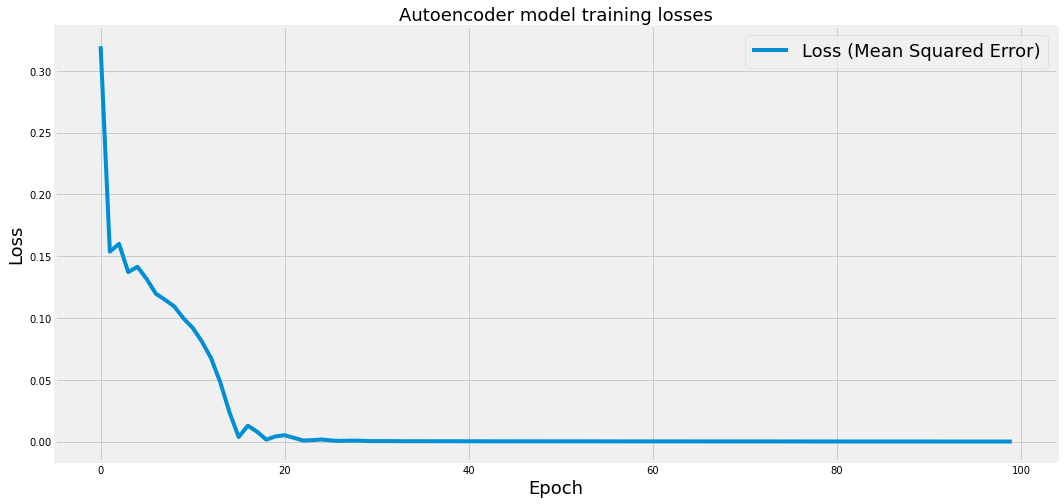


 RMSE:
1223.2491141142316


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


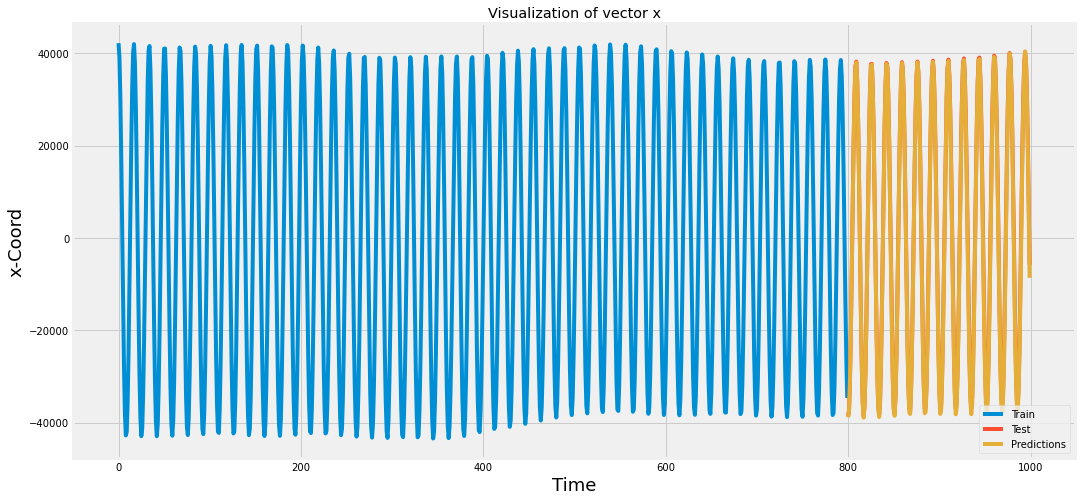

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 0s 117ms/step - loss: 0.2892
Epoch 2/100
3/3 [==============================] - 0s 144ms/step - loss: 0.1567
Epoch 3/100
3/3 [==============================] - 0s 151ms/step - loss: 0.1424
Epoch 4/100
3/3 [==============================] - 0s 143ms/step - loss: 0.1433
Epoch 5/100
3/3 [==============================] - 0s 140ms/step - loss: 0.1370
Epoch 6/100
3/3 [==============================] - 0s 144ms/step - loss: 0.1251
Epoch 7/100
3/3 [==============================] - 0s 146ms/step - loss: 0.1216
Epoch 8/100
3/3 [==============================] - 0s 159ms/step - loss: 0.1150
Epoch 9/100
3/3 [==============================] - 0s 151ms/step - loss: 0.1071
Epoch 10/100
3/3 [==============================] - 0s 134ms/step - loss: 0.1004
Epoch 11/100
3/3 [==============================] - 0s 136ms/step - loss: 0.0901
Epoch 12/100
3/3 [==============================] - 0s 130ms/step - loss: 0.0783
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 120ms/step - loss: 1.6451e-04
Epoch 99/100
3/3 [==============================] - 0s 119ms/step - loss: 1.6400e-04
Epoch 100/100
3/3 [==============================] - 0s 118ms/step - loss: 1.6025e-04


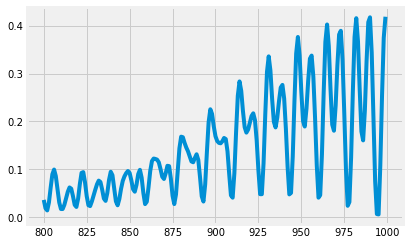

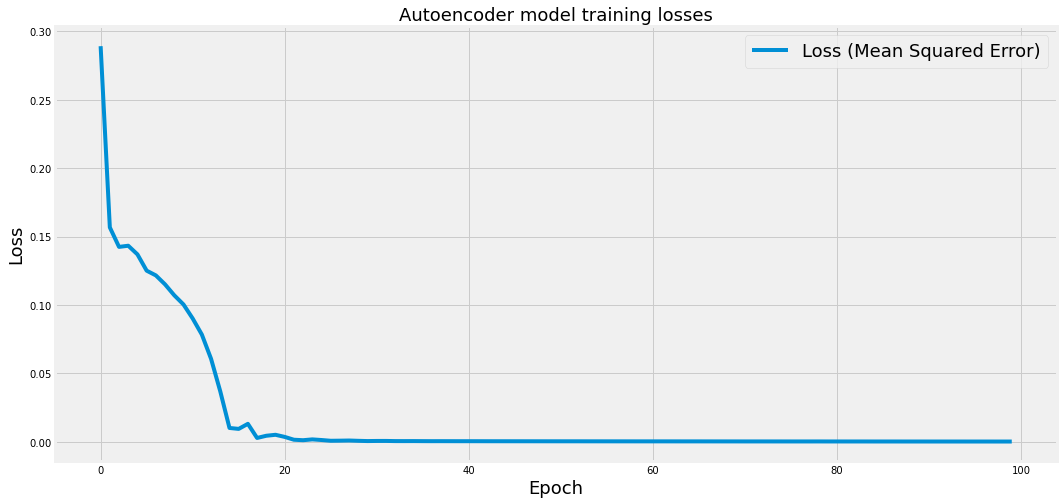


 RMSE:
891.2246011981033


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


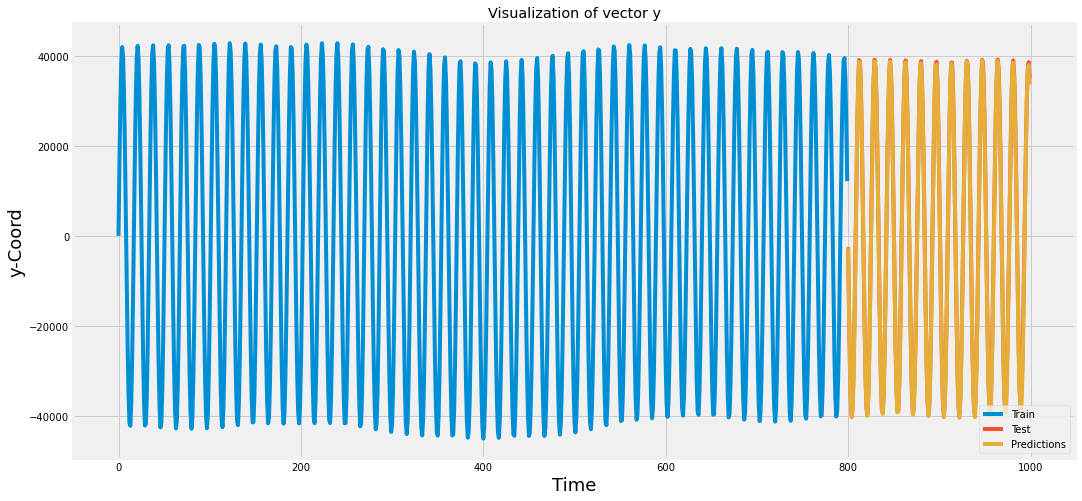

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 189ms/step - loss: 0.1736
Epoch 2/100
3/3 [==============================] - 1s 213ms/step - loss: 0.0814
Epoch 3/100
3/3 [==============================] - 1s 215ms/step - loss: 0.0663
Epoch 4/100
3/3 [==============================] - 1s 196ms/step - loss: 0.0694
Epoch 5/100
3/3 [==============================] - 1s 196ms/step - loss: 0.0655
Epoch 6/100
3/3 [==============================] - 1s 187ms/step - loss: 0.0572
Epoch 7/100
3/3 [==============================] - 1s 215ms/step - loss: 0.0591
Epoch 8/100
3/3 [==============================] - 1s 191ms/step - loss: 0.0571
Epoch 9/100
3/3 [==============================] - 1s 181ms/step - loss: 0.0524
Epoch 10/100
3/3 [==============================] - 1s 171ms/step - loss: 0.0520
Epoch 11/100
3/3 [==============================] - 1s 172ms/step - loss: 0.0497
Epoch 12/100
3/3 [==============================] - 1s 178ms/step - loss: 0.0466
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 129ms/step - loss: 1.0441e-04
Epoch 99/100
3/3 [==============================] - 0s 123ms/step - loss: 1.0495e-04
Epoch 100/100
3/3 [==============================] - 0s 137ms/step - loss: 1.0817e-04


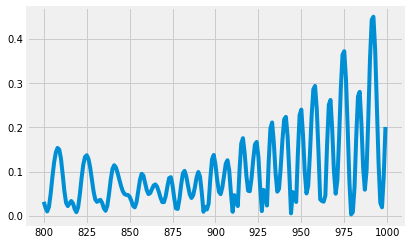

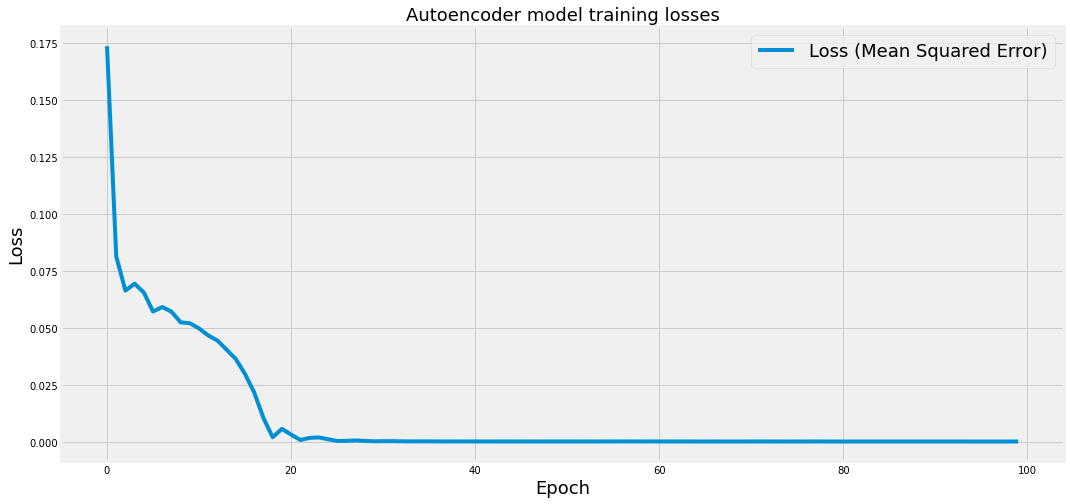


 RMSE:
470.8407789077646


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


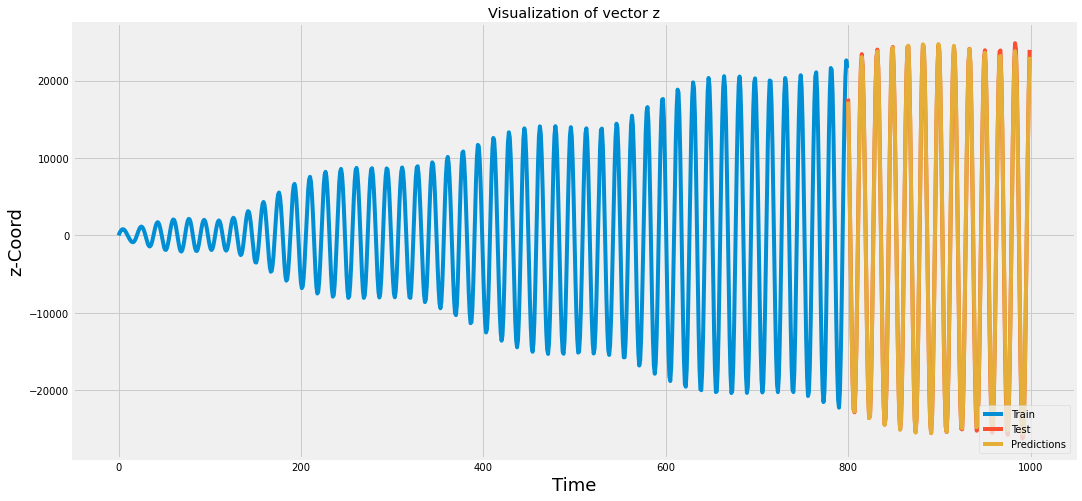

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 229ms/step - loss: 0.2081
Epoch 2/100
3/3 [==============================] - 1s 292ms/step - loss: 0.1517
Epoch 3/100
3/3 [==============================] - 1s 250ms/step - loss: 0.1319
Epoch 4/100
3/3 [==============================] - 1s 228ms/step - loss: 0.1313
Epoch 5/100
3/3 [==============================] - 1s 225ms/step - loss: 0.1172
Epoch 6/100
3/3 [==============================] - 1s 204ms/step - loss: 0.1106
Epoch 7/100
3/3 [==============================] - 1s 227ms/step - loss: 0.1012
Epoch 8/100
3/3 [==============================] - 1s 210ms/step - loss: 0.0898
Epoch 9/100
3/3 [==============================] - 1s 204ms/step - loss: 0.0769
Epoch 10/100
3/3 [==============================] - 1s 191ms/step - loss: 0.0577
Epoch 11/100
3/3 [==============================] - 1s 179ms/step - loss: 0.0331
Epoch 12/100
3/3 [==============================] - 1s 180ms/step - loss: 0.0087
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 132ms/step - loss: 1.8655e-04
Epoch 99/100
3/3 [==============================] - 0s 124ms/step - loss: 1.8516e-04
Epoch 100/100
3/3 [==============================] - 0s 134ms/step - loss: 1.8426e-04


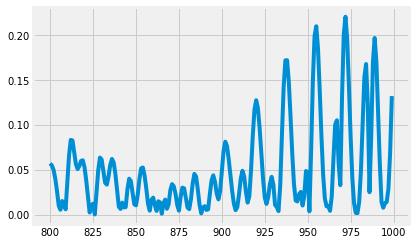

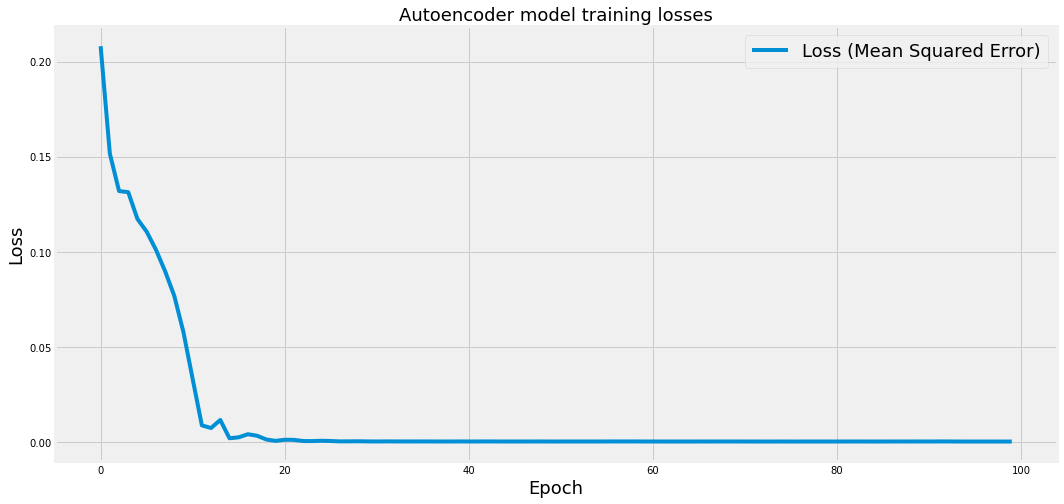


 RMSE:
0.060013455587107294


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


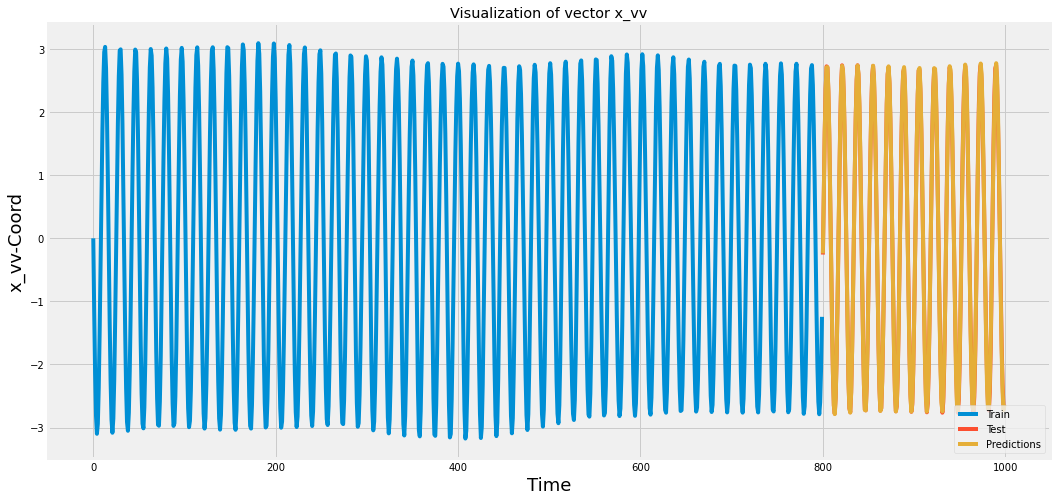

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 232ms/step - loss: 0.2225
Epoch 2/100
3/3 [==============================] - 1s 259ms/step - loss: 0.1517
Epoch 3/100
3/3 [==============================] - 1s 237ms/step - loss: 0.1344
Epoch 4/100
3/3 [==============================] - 1s 246ms/step - loss: 0.1359
Epoch 5/100
3/3 [==============================] - 1s 218ms/step - loss: 0.1283
Epoch 6/100
3/3 [==============================] - 1s 189ms/step - loss: 0.1171
Epoch 7/100
3/3 [==============================] - 1s 184ms/step - loss: 0.1137
Epoch 8/100
3/3 [==============================] - 1s 195ms/step - loss: 0.1051
Epoch 9/100
3/3 [==============================] - 1s 184ms/step - loss: 0.0970
Epoch 10/100
3/3 [==============================] - 1s 189ms/step - loss: 0.0869
Epoch 11/100
3/3 [==============================] - 1s 185ms/step - loss: 0.0728
Epoch 12/100
3/3 [==============================] - 0s 167ms/step - loss: 0.0542
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 121ms/step - loss: 2.2006e-04
Epoch 99/100
3/3 [==============================] - 0s 129ms/step - loss: 2.3239e-04
Epoch 100/100
3/3 [==============================] - 0s 122ms/step - loss: 2.1104e-04


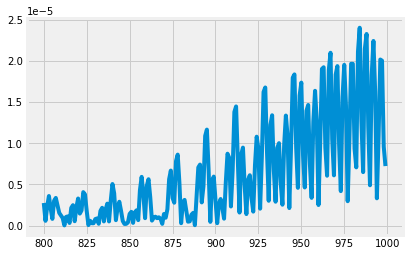

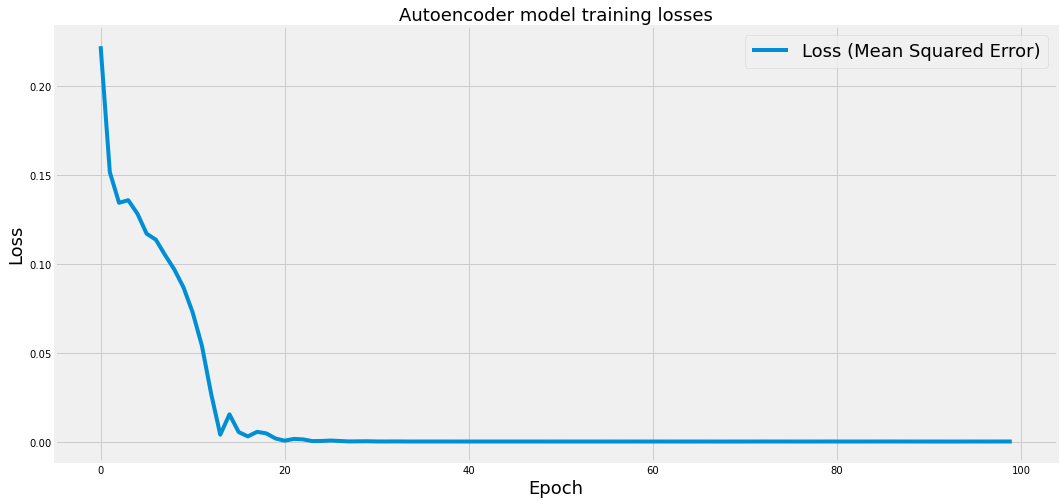


 RMSE:
0.07368521419520263


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


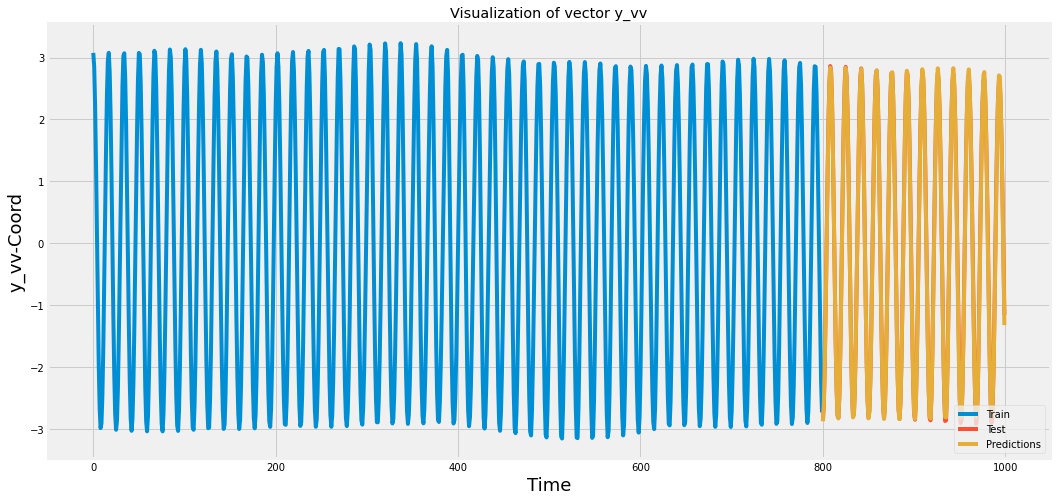

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 194ms/step - loss: 0.1667
Epoch 2/100
3/3 [==============================] - 1s 210ms/step - loss: 0.0851
Epoch 3/100
3/3 [==============================] - 1s 203ms/step - loss: 0.0641
Epoch 4/100
3/3 [==============================] - 1s 203ms/step - loss: 0.0697
Epoch 5/100
3/3 [==============================] - 1s 197ms/step - loss: 0.0662
Epoch 6/100
3/3 [==============================] - 1s 193ms/step - loss: 0.0575
Epoch 7/100
3/3 [==============================] - 1s 191ms/step - loss: 0.0565
Epoch 8/100
3/3 [==============================] - 1s 178ms/step - loss: 0.0556
Epoch 9/100
3/3 [==============================] - 1s 178ms/step - loss: 0.0515
Epoch 10/100
3/3 [==============================] - 1s 171ms/step - loss: 0.0498
Epoch 11/100
3/3 [==============================] - 1s 174ms/step - loss: 0.0479
Epoch 12/100
3/3 [==============================] - 1s 173ms/step - loss: 0.0442
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 125ms/step - loss: 1.1214e-04
Epoch 99/100
3/3 [==============================] - 0s 130ms/step - loss: 1.1554e-04
Epoch 100/100
3/3 [==============================] - 0s 128ms/step - loss: 1.1827e-04


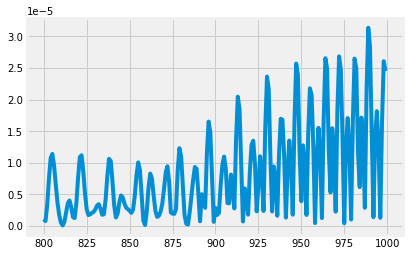

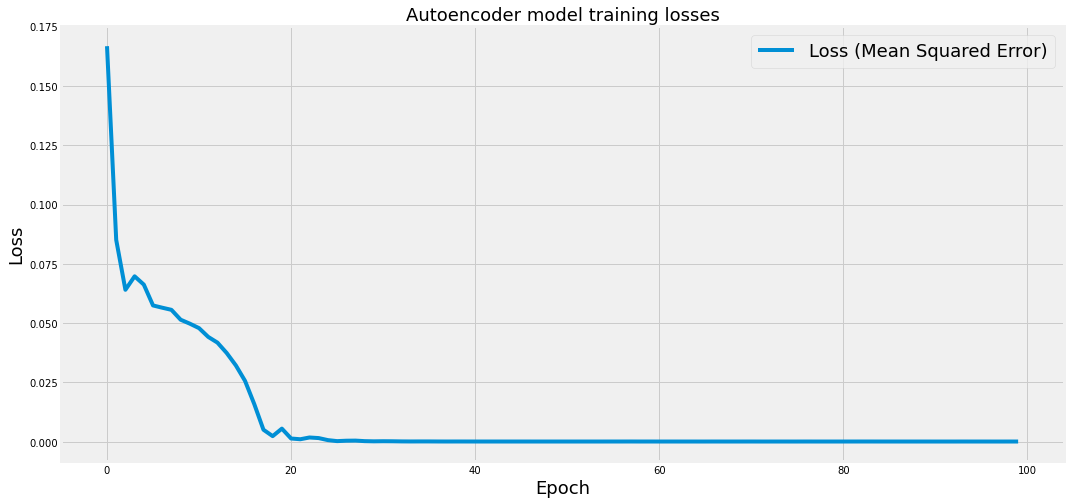


 RMSE:
0.036279892371808606


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


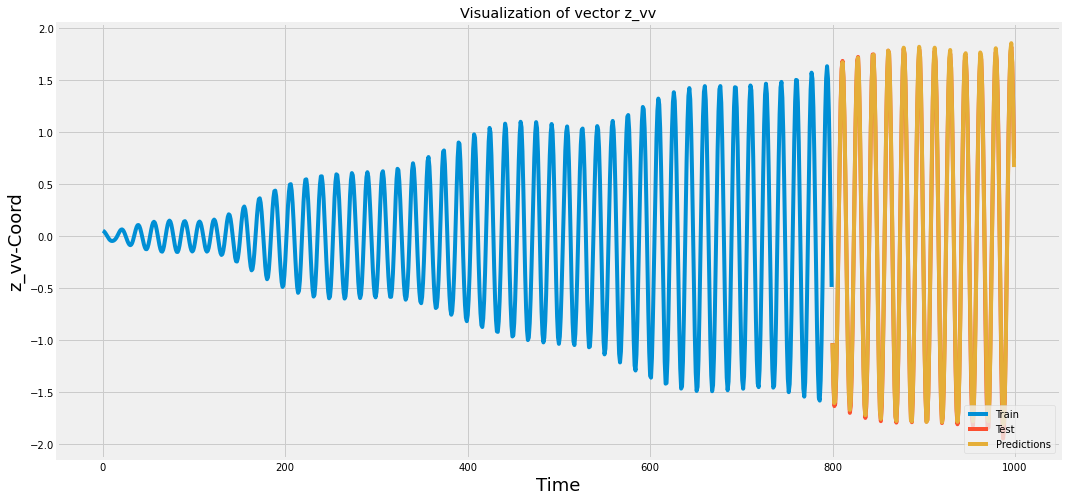

Wall time: 7min 2s


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,x,y,z,x_vv,y_vv,z_vv
0,-38864.742188,-2765.156982,17296.628906,-0.238755,-2.877547,-1.028610
1,-37405.152344,-17062.835938,10872.205078,0.772668,-2.615446,-1.417215
2,-30921.304688,-29073.882812,2872.561523,1.673505,-2.007842,-1.603068
3,-20366.113281,-37205.128906,-5572.039062,2.348913,-1.135857,-1.567141
4,-7185.989258,-40357.382812,-13280.140625,2.712425,-0.113482,-1.320573
...,...,...,...,...,...,...
195,38194.878906,20325.224609,-7816.679199,-0.930540,2.292527,1.783589
196,30866.466797,30856.558594,1527.296875,-1.812342,1.569591,1.856557
197,19467.437500,37026.343750,10586.303711,-2.435980,0.634867,1.671957
198,5655.540039,37998.804688,18121.548828,-2.721270,-0.375817,1.256100


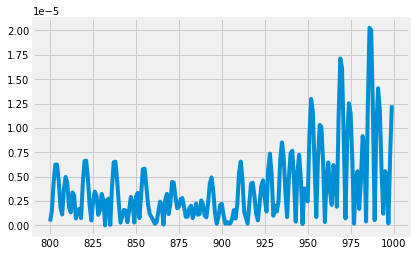

In [5]:
%%time
# 6D Call:

# Init empty predictions DF
df_pred= pd.DataFrame(columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv'])

for vector in list(df.columns):
    train_vector(df, vector)

df_pred

In [6]:
# Transform this df_pred to OE with the function transform.py

### Compare and plot results/errors SEPARATELY

In [7]:
train_size = int(len(df) * 0.8) 

test_df = df[train_size:]
train_df = df[:train_size]

test_df

,x,y,z,x_vv,y_vv,z_vv
800,-38621.084811,-2550.946846,17682.193978,-0.257209,-2.870446,-1.025837
801,-37279.380962,-16940.060722,11242.557363,0.768795,-2.610164,-1.427567
802,-30825.302422,-29006.586493,3208.718635,1.689373,-1.985552,-1.632349
803,-20158.481503,-37068.221540,-5302.080061,2.373066,-1.085660,-1.609145
804,-6770.864726,-40022.999588,-13103.503585,2.726621,-0.041149,-1.362677
...,...,...,...,...,...,...
995,38234.560983,21122.626943,-7729.980003,-0.857195,2.210305,1.746021
996,31594.564686,31056.038869,1622.694286,-1.676526,1.578339,1.821188
997,21172.777063,37155.711937,10779.298456,-2.301089,0.745975,1.670545
998,8179.033302,38600.411058,18585.398385,-2.656710,-0.200198,1.303776


In [8]:
df_pred.index=test_df.index

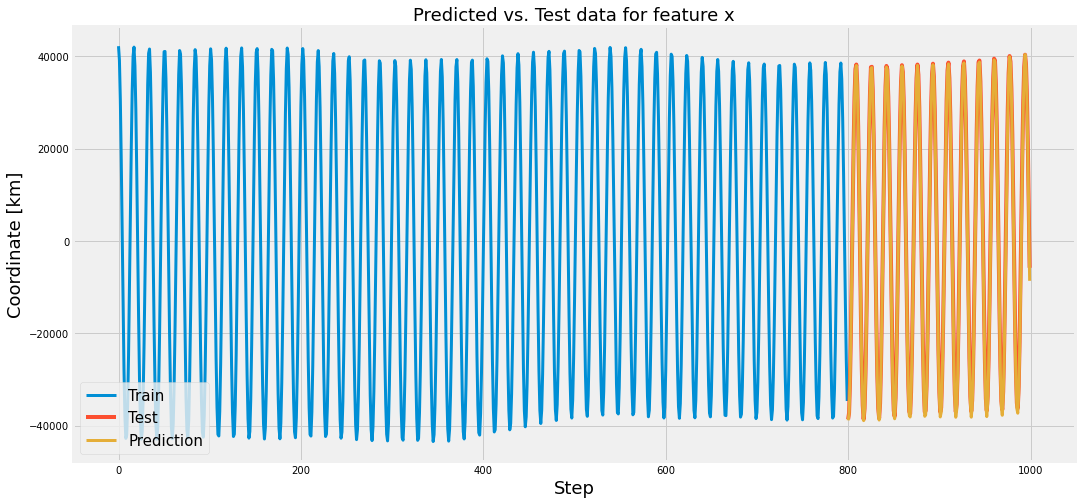

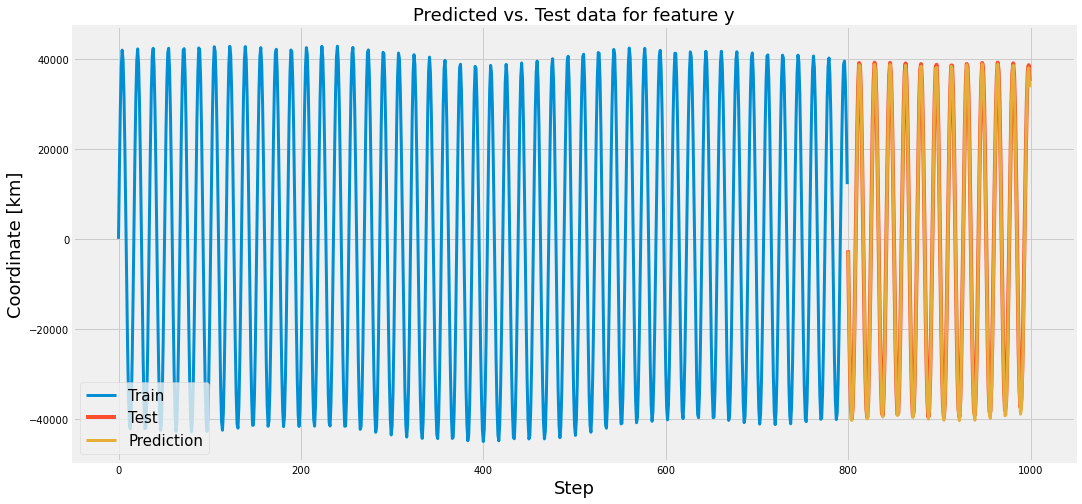

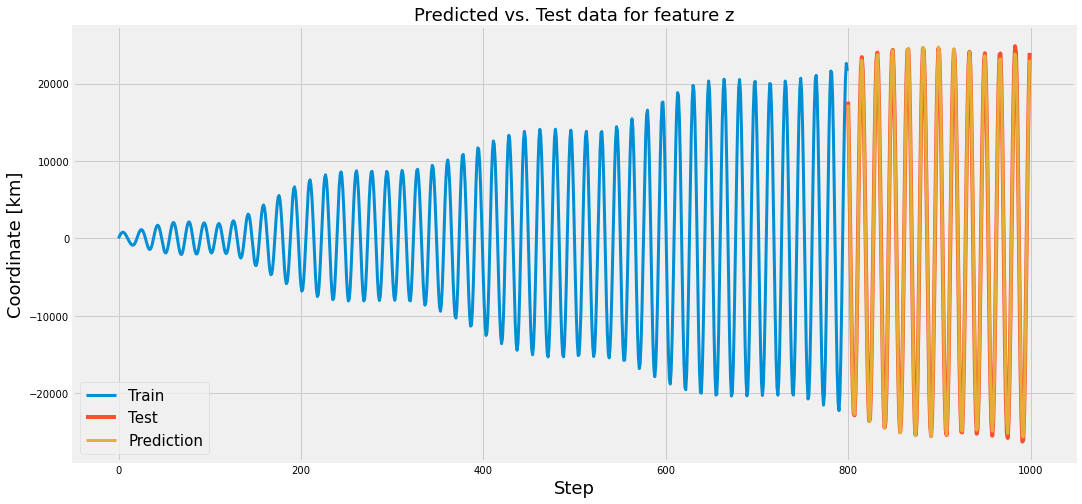

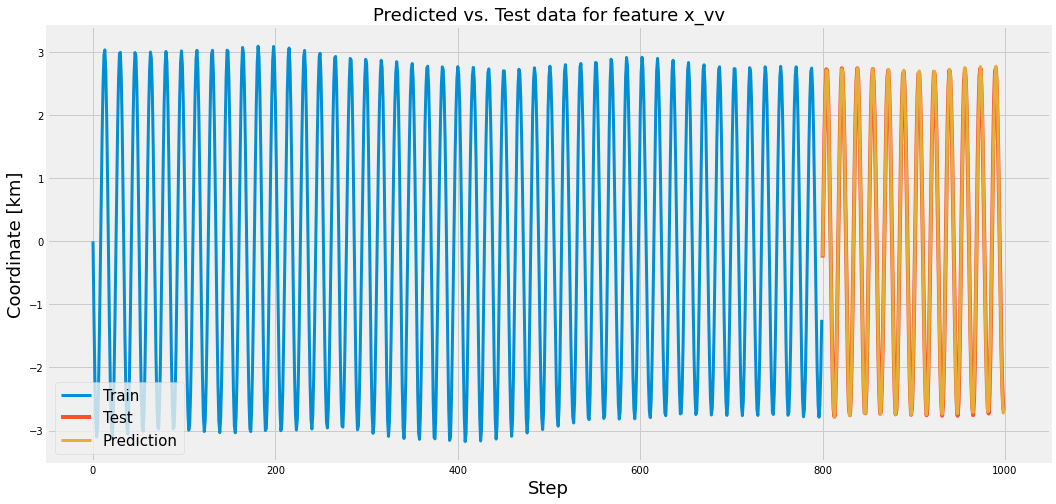

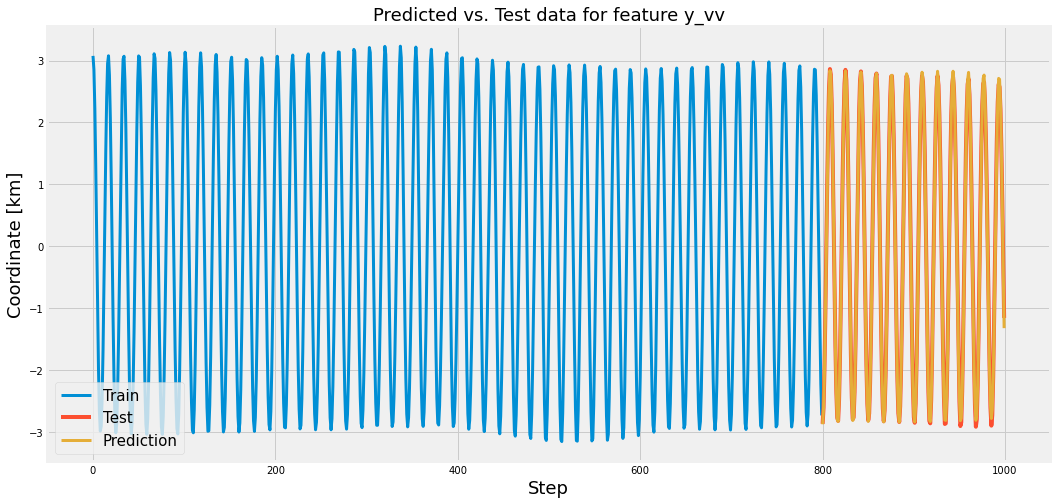

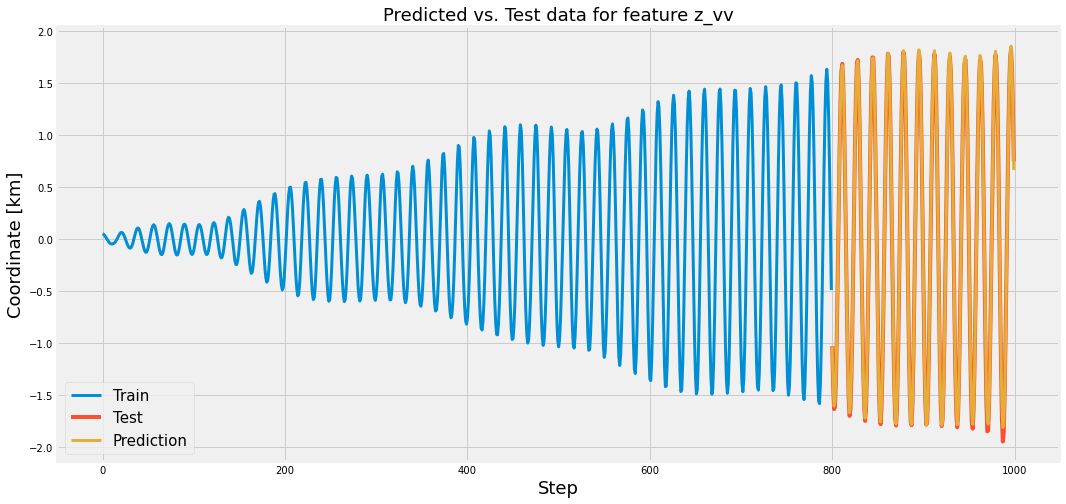

In [9]:
for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(train_df[feature], linewidth=3)
    plt.plot(test_df[feature], linewidth=4)
    plt.plot(df_pred[feature], linewidth=3)

    plt.title(f'Predicted vs. Test data for feature {feature}', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Coordinate [km]', fontsize=18)
    plt.legend(['Train', 'Test', 'Prediction'], loc='lower left', fontsize=15)
    plt.show()


## RMSE:

In [10]:
print('RMSE for all Features:')
print()

for i in list(test_df.columns):
    print(i)
    rmse = np.sqrt(np.mean(((test_df[i] - df_pred[i]) ** 2)))
    print(rmse)

RMSE for all Features:

x
1223.2491141142316
y
891.2246011981033
z
470.8407789077646
x_vv
0.060013455587107294
y_vv
0.07368521419520263
z_vv
0.036279892371808606


## Absolute errors:

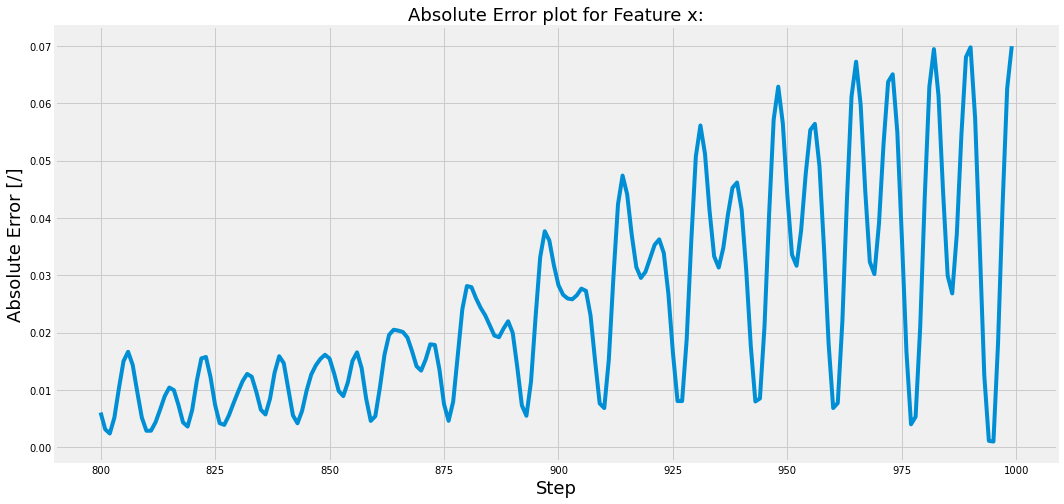

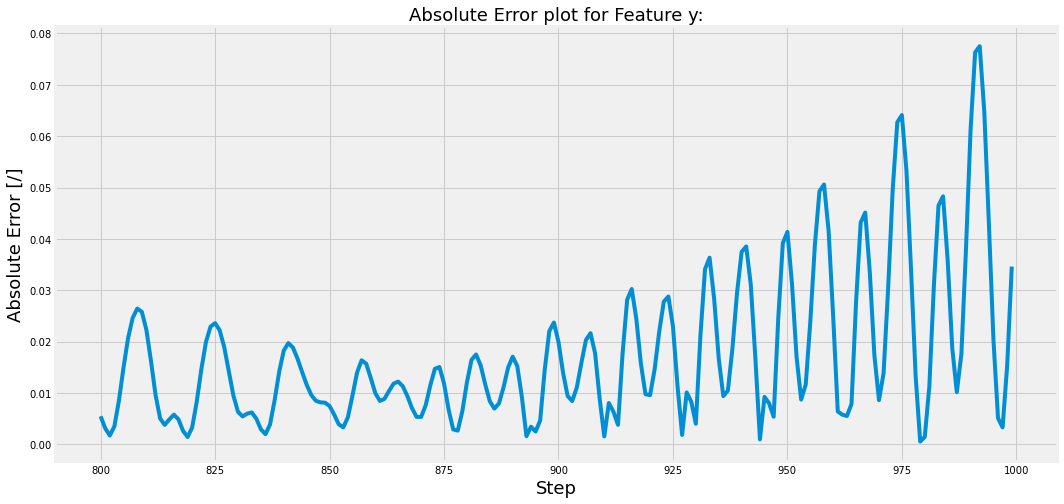

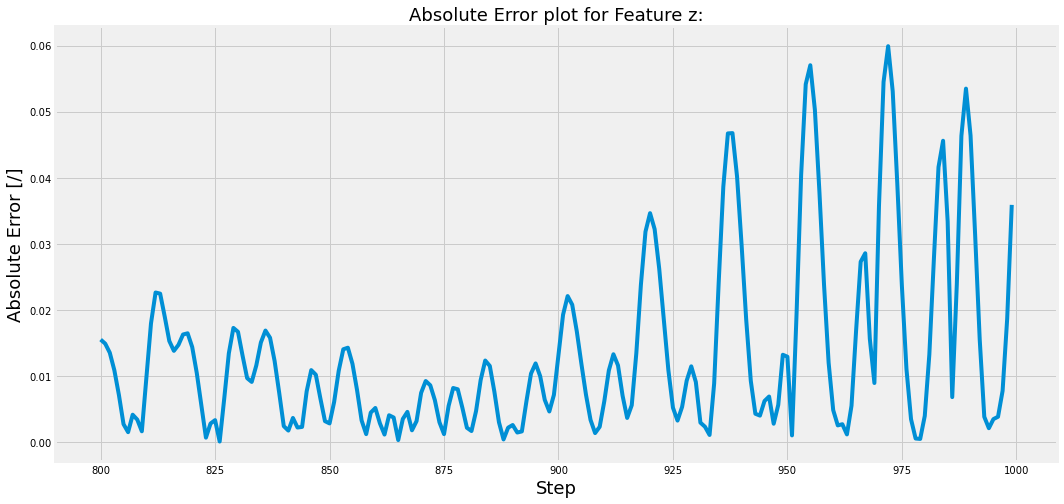

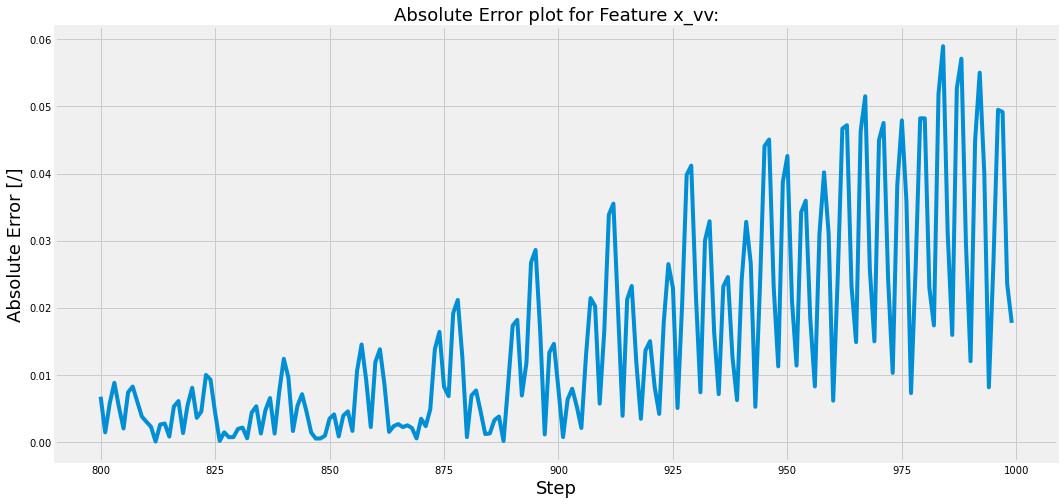

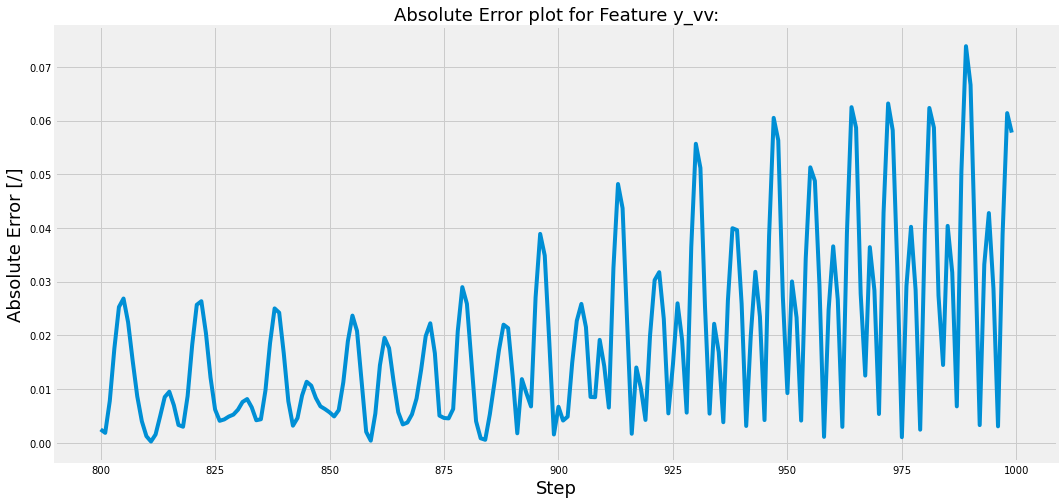

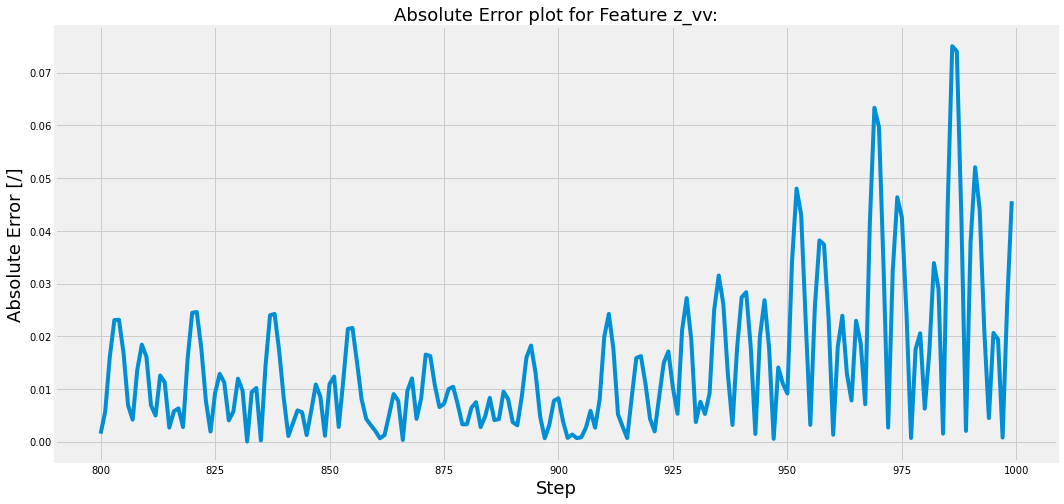

In [11]:
# ABSOLUTE ERRORS:

for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(abs(df_pred[feature]-test_df[feature])/max(test_df[feature]))

    plt.title(f'Absolute Error plot for Feature {feature}:', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Absolute Error [/]', fontsize=18)
    plt.show()

In [12]:
# AVG ABSOLUTE ERRORS:

print('Mean Absolute Errors:')
print()
for i in list(test_df.columns):
    print(i)
    abs_err=abs(df_pred[i]-test_df[i])/max(test_df[i])
    print(abs_err.mean())

Mean Absolute Errors:

x
0.024544936641095697
y
0.01733408069861533
z
0.013390241526514109
x_vv
0.015801031118925744
y_vv
0.019633253280416662
z_vv
0.014388634064757842


## Relative errors:

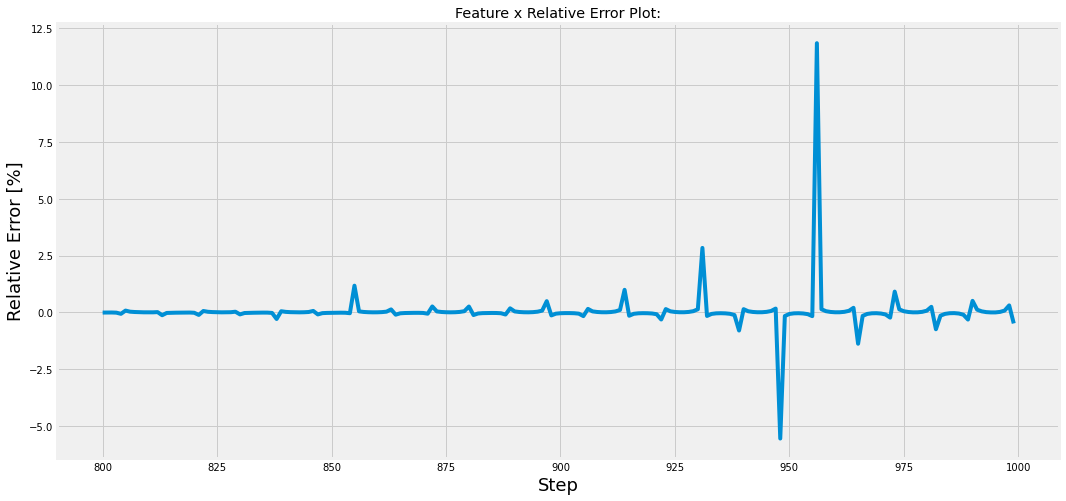

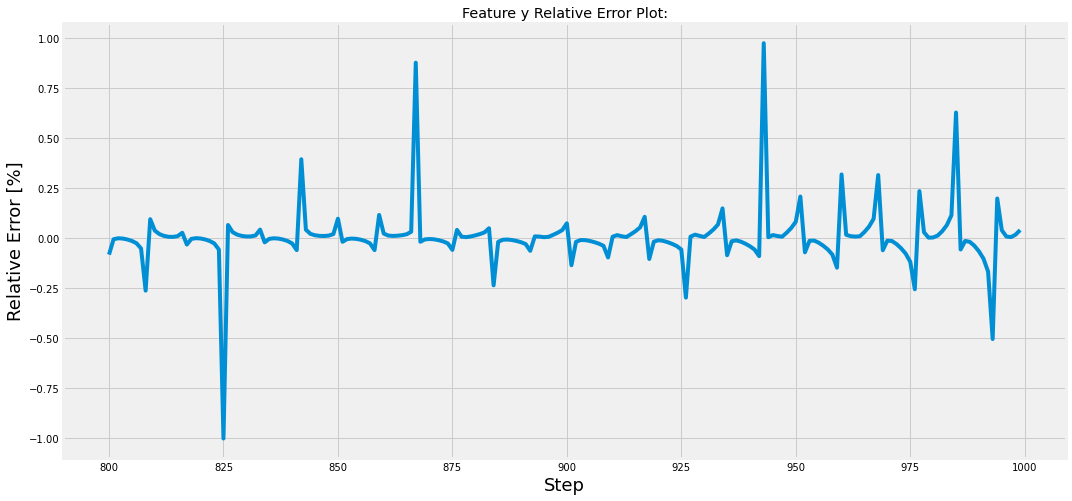

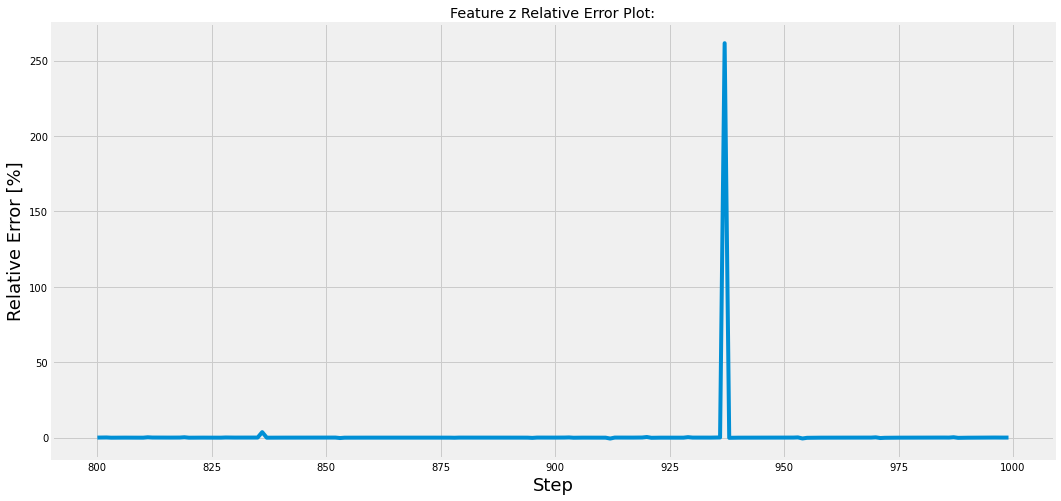

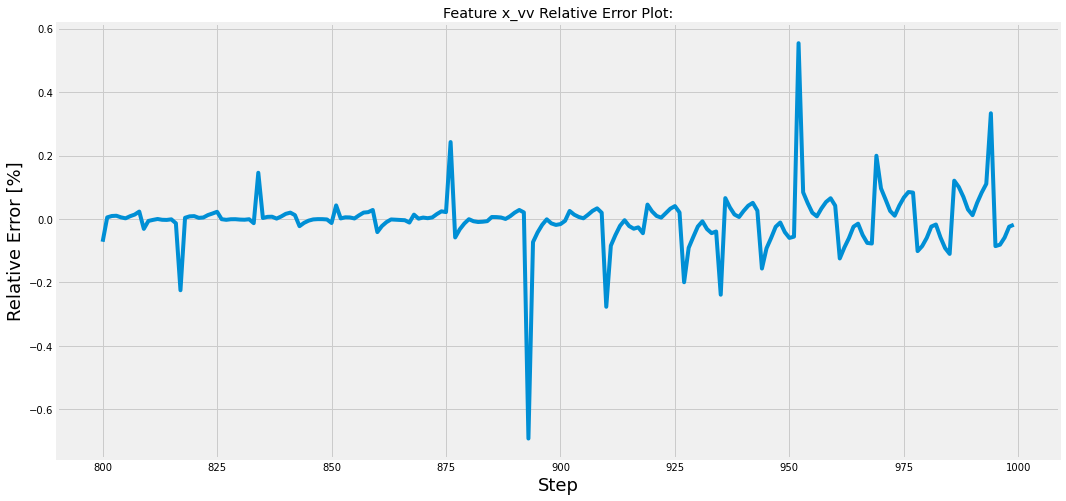

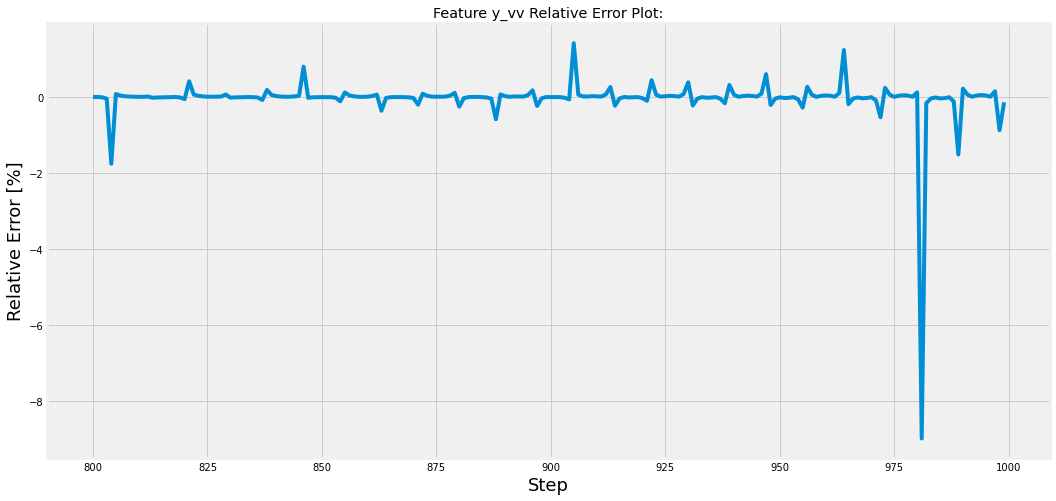

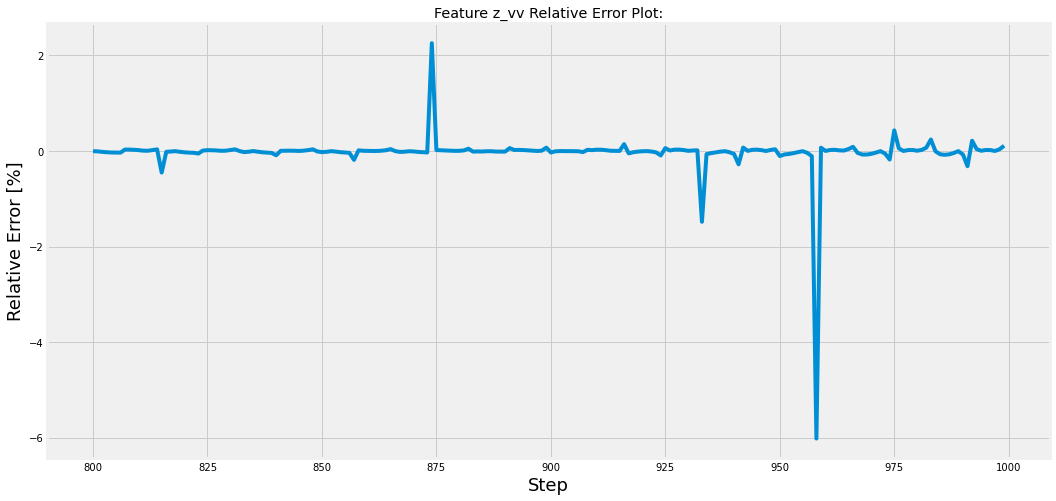

In [13]:
# RELATIVE ERRORS

for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(abs(df_pred[feature]-test_df[feature])/test_df[feature])

    plt.title(f'Feature {feature} Relative Error Plot:')
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Relative Error [%]', fontsize=18)
    plt.show()

In [14]:
# AVG RELATIVE ERRORS:

print('Mean Relative Errors as PERCENTAGE:')
print()
for i in list(test_df.columns):
    print(i)
    abs_err=abs(df_pred[i]-test_df[i])/test_df[i]*100
    print(abs_err.mean())

Mean Relative Errors as PERCENTAGE:

x
4.589095808444612
y
0.34142891876936254
z
132.52437304154378
x_vv
-0.3219840850013948
y_vv
-4.606041123823143
z_vv
-3.103358019714685


## Compare and Plot 3D trajectories/errors:

### 1. For 3D Position coordinates

<Figure size 432x288 with 0 Axes>

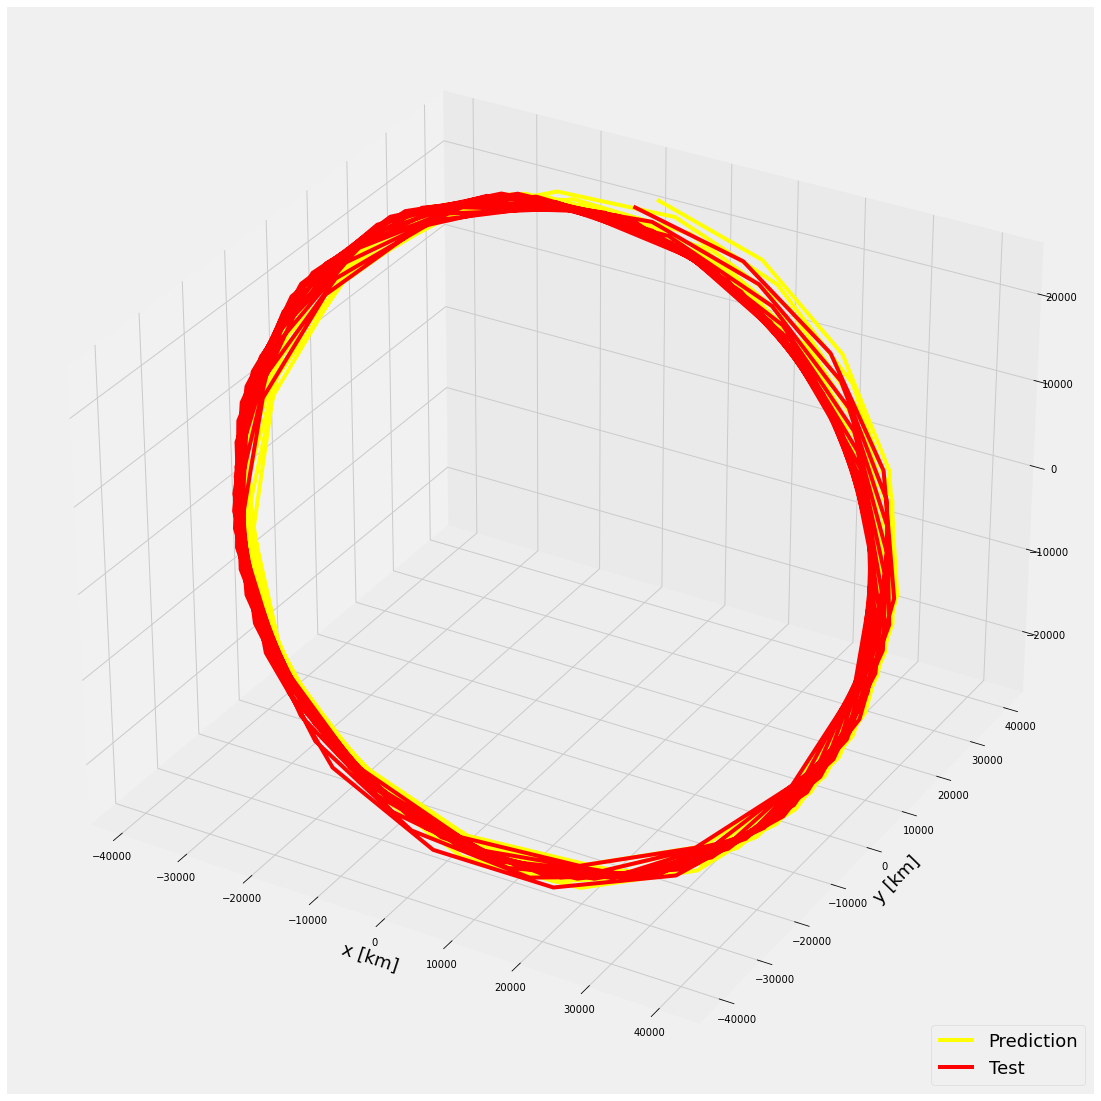

In [20]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")

x_line2 = test_df['x']
y_line2 = test_df['y']
z_line2 = test_df['z']
plt.plot(x_line2, y_line2, z_line2, 'yellow')

x_line = df_pred['x']
y_line = df_pred['y']
z_line = df_pred['z']
plt.plot(x_line, y_line, z_line, 'red')

#plt.title('Predicted vs. Test Orbit 3D Propagation', fontsize=18)
plt.xlabel('x [km]', fontsize=18)
plt.ylabel('y [km]', fontsize=18)
#plt.zlabel('z [m]', fontsize=18)
plt.legend(['Prediction', 'Test'], loc='lower right', fontsize=18)
plt.show()

### 2. For 3D velocity coordinates

## 3D Errors

### 1. Distance Error

https://www.engineeringtoolbox.com/distance-relationship-between-two-points-d_1854.html

In [ ]:
# Init empty DF for errors
df_err= pd.DataFrame(columns=['x_test', 'y_test', 'z_test', 'x_pred', 'y_pred', 'z_pred'])

df_err['x_test']=test_df['x']
df_err['y_test']=test_df['y']
df_err['z_test']=test_df['z']

df_err['x_pred']=df_pred['x']
df_err['y_pred']=df_pred['y']
df_err['z_pred']=df_pred['z']

df_err

In [ ]:
import math

# Difference in distance in 3D (Position)

df_err['distance_error'] = ( (df_err.x_test-df_err.x_pred)**2 + (df_err.y_test-df_err.y_pred)**2 + (df_err.z_test-df_err.z_pred)**2 )**(1/2)
df_err['distance_error'].apply(lambda x: float(x))
df_err

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df_err.distance_error)
plt.title('Distance error for 3D position vectors (r):')
plt.xlabel('Step', fontsize=18)
plt.ylabel('Distance Error [km]', fontsize=18)
plt.show()